<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/project/07nov2021/TimeSeriesSplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install pandas-ta==0.2.45b

     |████████████████████████████████| 6.4 MB 13.7 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 88 kB 4.5 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.2.45b0-py3-none-any.whl size=175303 sha256=e5b52789a874ac953beaa049026bf52fe3dc9cc6c6c9ee7643ed67f9ea790ea

In [2]:
!pip install colorama

In [3]:
import yfinance as yf
import pandas_ta as ta
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,f1_score
import datetime as dt

from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
import matplotlib
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

In [4]:
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
           


In [5]:
data_for_modeling=yf.download('^nsei',start='2015-01-01',parse_dates=['Date']).reset_index()

[*********************100%***********************]  1 of 1 completed


In [6]:
data_for_modeling['Date']=data_for_modeling['Date'].map(dt.datetime.toordinal)

In [7]:
data_for_modeling.ta.macd(append=True)
data_for_modeling.ta.vortex(append=True)
print()

In [8]:
#data_for_modeling.rename(columns={'date':'Date'},inplace=True)

In [9]:
features=data_for_modeling.columns.tolist()

In [10]:
features=[feats for feats in features if feats not in ['close','open','low','high']]

In [11]:
data_for_modeling['Signal']=data_for_modeling['close'].transform(lambda x : np.sign(x.diff(30)))


In [12]:
data_for_modeling=data_for_modeling.dropna()

In [13]:
X=data_for_modeling[features]
y=data_for_modeling['Signal']

In [14]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print("Fold: {}".format(fold))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


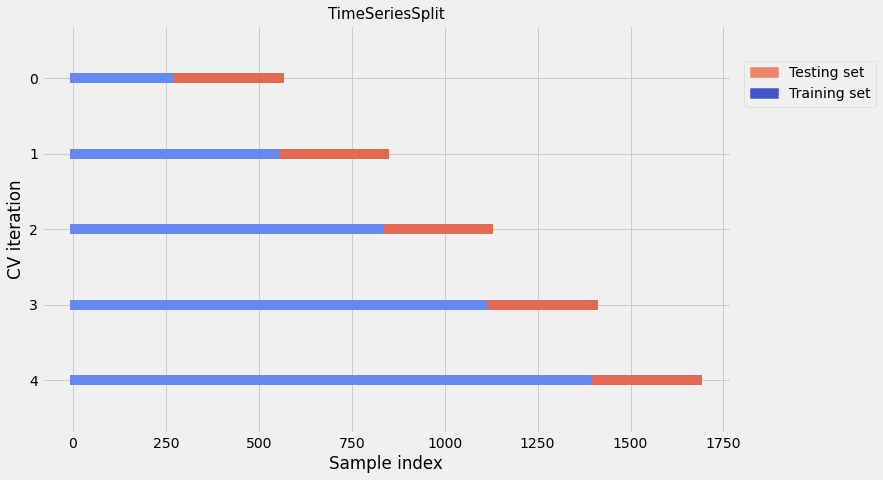

In [15]:
plot_cv_indices(tscv,5, X, y)

In [16]:

for train_index, test_index in tscv.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("Train Start: %d -> End %d" % (train_index[0], train_index[-1]))
    print("Test Start: %d -> End %d" % (test_index[0], test_index[-1]))
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    print("#" * 50)

Train Start: 0 -> End 280
Test Start: 281 -> End 561
(281, 8) (281,)
(281, 8) (281,)
##################################################
Train Start: 0 -> End 561
Test Start: 562 -> End 842
(562, 8) (562,)
(281, 8) (281,)
##################################################
Train Start: 0 -> End 842
Test Start: 843 -> End 1123
(843, 8) (843,)
(281, 8) (281,)
##################################################
Train Start: 0 -> End 1123
Test Start: 1124 -> End 1404
(1124, 8) (1124,)
(281, 8) (281,)
##################################################
Train Start: 0 -> End 1404
Test Start: 1405 -> End 1685
(1405, 8) (1405,)
(281, 8) (281,)
##################################################


In [17]:
X_train.shape,X_test.shape

((1405, 8), (281, 8))

In [18]:
rf=RandomForestClassifier()

In [19]:
rand_frst_clf = RandomForestClassifier(n_estimators = 200,max_depth=20,min_samples_leaf=3,max_features = "auto",min_samples_split=40, criterion = "gini", bootstrap=True,random_state = 42)

In [20]:

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=3, min_samples_split=40,
                       n_estimators=200, random_state=42)

In [21]:
# Make predictions
y_pred = rand_frst_clf.predict(X_test)

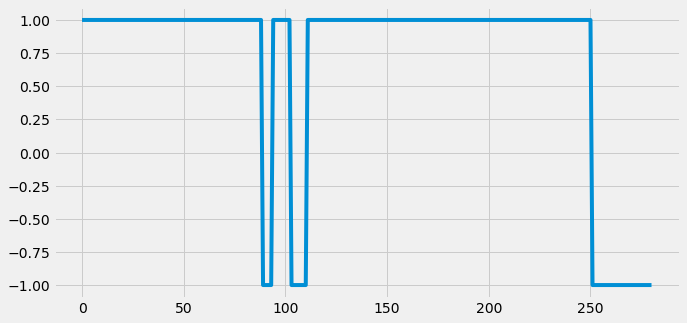

In [22]:
plt.figure(figsize=(10,5))
pd.Series(y_pred).plot();

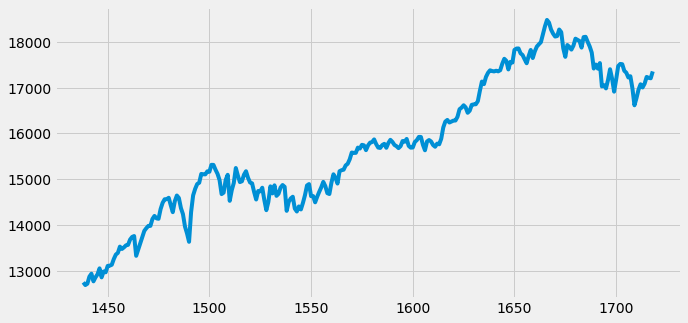

In [23]:
plt.figure(figsize=(10,5))
X_test['adj_close'].plot();

In [30]:
timeseries=pd.concat([X_test['adj_close'].reset_index(),pd.Series(y_pred)],axis=1)

In [32]:
timeseries.columns=['index','close','prediction']

In [33]:
timeseries.set_index('index',inplace=True)

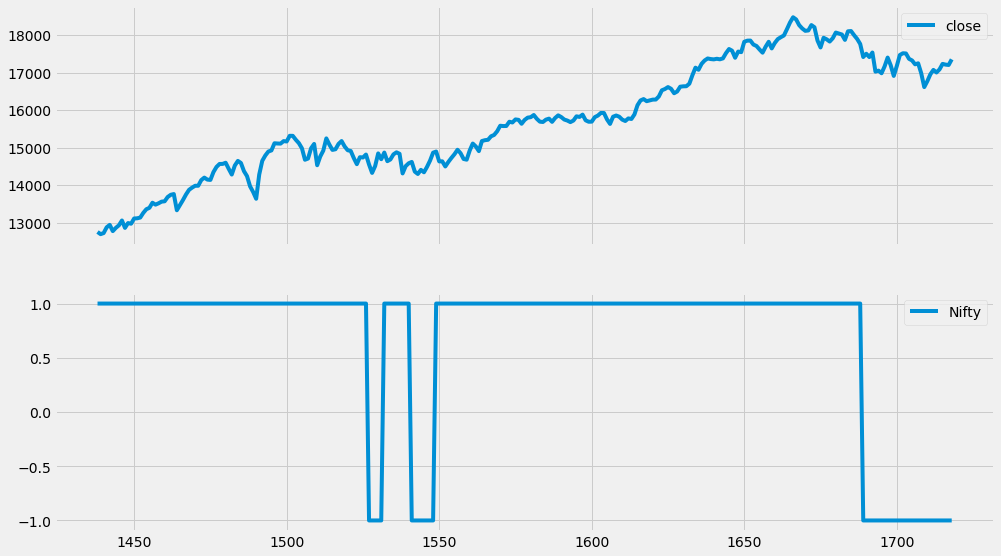

In [34]:
fig, ax = plt.subplots(2,1, figsize=(15,9),sharex=True)
ax[0].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'close'], label='close')
ax[1].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'prediction'], label='Nifty')
ax[0].legend()
ax[1].legend()
plt.show()